In [1]:
%cd ../

/notebooks/mt-tabnet-xgboost-model-comparison


In [4]:
import argparse
from genericpath import exists
import json
import pickle
import os
from fastai.tabular.all import EarlyStoppingCallback, SaveModelCallback, GradientClip, CSVLogger
from model_trainer.tabnet.utils import get_optimizer_from_params
from model_trainer.tabnet.tabnet_trainer import TabNetTrainer
from model_trainer.data import data_loader
from model_trainer.data.process_only_data_box import ProccessOnlyDataBox
from tuning_config import spaces, base_class_weights_large
import data_config
from hyperopt import space_eval
import numpy as np
from torch import tensor
# TODO: import this
from fast_tabnet.core import tabnet_explain, tabnet_feature_importances
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, matthews_corrcoef

def process_params(params):
    cw_modifier = params.pop('cw_modifier')
    class_weights = base_class_weights_large.copy()
    class_weights[1]=class_weights[1]*cw_modifier
    class_weights = tensor(np.array(class_weights,dtype='f'))
    batch_size = int(np.power(2, params.pop('batch_size')))
    params['virtual_batch_size'] = int(
        np.power(2, params['virtual_batch_size']))

    opt_params = params.pop('optimizer')
    opttype = opt_params.pop('opttype')
    lookahead = opt_params.pop('lookahead')
    lr = opt_params.pop('lr')
    optimizer = get_optimizer_from_params(opttype, opt_params, lookahead)

    n = params.pop('n')
    params['n_d'] = n
    params['n_a'] = n
    return params, optimizer, batch_size, class_weights, lr

In [7]:
data_size="small"
evals=10
base_data_path="data"
epochs=1
patience=1
info_output_path="info-test"

print("Loading data")
X_train, Y_train = data_loader.load(
    data_size, base_data_path, 'train_val')
X_test, Y_test = data_loader.load(
    data_size,base_data_path,'test' 
)
print("Processing data")
po_db = ProccessOnlyDataBox(X_train, Y_train, X_test, Y_test, data_config.categorical_variables)
X_train, Y_train, X_test, Y_test = next(po_db.get_processed_data())

os.makedirs(info_output_path,exist_ok=True) # creating info output dir
callbacks = [
    CSVLogger(fname=f'{info_output_path}/train_history.csv', append=False),
    GradientClip(),
    EarlyStoppingCallback(
        monitor='valid_loss',
        patience=patience,
        reset_on_fit=True
    ),
    SaveModelCallback(
        monitor='matthews_corrcoef',
        fname=f'tabnet-{data_size}-model',
        at_end=False,
        with_opt=True,
        reset_on_fit=True
    )
]

trials_in_path = f"trials/tabnet-{data_size}.p"
print(f"Loading trial from path: {trials_in_path}")
with open(trials_in_path, 'rb') as in_file:
    trials = pickle.load(in_file)

space = spaces['tabnet'][data_size]
best_hyperparams = space_eval(space, trials.argmin)
print(f"Starting training with best params:\n{json.dumps(best_hyperparams,indent=4)}")
model_params, optimizer, batch_size, class_weights,lr = process_params(best_hyperparams)
# TODO: F1, accuracy, confusion metrics
tt = TabNetTrainer(lr,model_params, optimizer,
            batch_size, callbacks, class_weights)
model = tt.train(X_train, Y_train, X_test, Y_test, data_config.continous_variables,epochs)


Loading data
Processing data
Loading trial from path: trials/tabnet-small.p
Starting training with best params:
{
    "batch_size": 8.0,
    "cw_modifier": 1.5,
    "gamma": 1.6764244526616359,
    "momentum": 0.6341653649702229,
    "n": 32,
    "n_steps": 4,
    "optimizer": {
        "lookahead": true,
        "lr": 0.008776074534175875,
        "opttype": "Adam",
        "wd": 0.0015690117123744126
    },
    "virtual_batch_size": 5.0
}
[0, 1.3266687393188477, 1.3194644451141357, 0.10915141466452281, '01:26']
Better model found at epoch 0 with matthews_corrcoef value: 0.10915141466452281.


In [8]:
preds_0=np.argmax(np.array(preds[0]),axis=1)
mcc = matthews_corrcoef(Y_test,preds_0)
print(f"mcc: {mcc}")
f1_weighted = f1_score(Y_test,preds_0,average='weighted')
print(f"f1 weighted: {f1_weighted}")
accuracy = accuracy_score(Y_test,preds_0)
print(f"accuracy: {accuracy}%")
confusion_mat = confusion_matrix(Y_test,preds_0)
print(f"confusion mat:\n{confusion_mat}")

metrics = {
    "mcc": mcc,
    "f1": f1_weighted,
    "confusion_m":confusion_mat,
    "acc": accuracy
}



mcc: 0.12092361969334955
f1 weighted: 0.8226074220659618
accuracy: 0.8255750610645439%
confusion mat:
[[  101   407     6     7]
 [ 1045 46173  2677   765]
 [   55  2346   579   122]
 [   37  2028   431   128]]


In [38]:
Y_test

0        2
1        1
2        2
3        1
4        0
        ..
56902    3
56903    1
56904    1
56905    1
56906    1
Name: Severity, Length: 56907, dtype: int64

In [10]:
model.dls.valid.device

device(type='cuda', index=0)

In [27]:
from scipy.sparse import csc_matrix
def tabnet_feature_importances(model, dl):
    model.eval()
    feature_importances_ = np.zeros((model.post_emb))
    for batch_nb, data in enumerate(dl):
        M_explain, masks = model.forward_masks(data[0].to('cuda'), data[1].to('cuda'))
        feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

    feature_importances_ = csc_matrix.dot(
        feature_importances_, model.emb_reducer
    )
    return feature_importances_ / np.sum(feature_importances_)

In [29]:
feature_importances = tabnet_feature_importances(model.model, model.dls.valid)

In [33]:
feature_importances

array([0.00735832, 0.00479366, 0.06057506, 0.02891171, 0.01396875,
       0.02462938, 0.02614589, 0.0063626 , 0.00792252, 0.02299424,
       0.02276618, 0.00769258, 0.03741603, 0.01117811, 0.00738222,
       0.01704158, 0.00320844, 0.00740922, 0.00169596, 0.01999713,
       0.01389127, 0.00628958, 0.01468491, 0.01957409, 0.00668167,
       0.01011557, 0.02436337, 0.02732481, 0.00117666, 0.01473139,
       0.0022148 , 0.01422105, 0.00937044, 0.01952234, 0.00603034,
       0.05661331, 0.01445347, 0.0110384 , 0.01962402, 0.12841623,
       0.06279307, 0.03121156, 0.00509751, 0.00465664, 0.02977444,
       0.02324698, 0.00936159, 0.00171716, 0.00309974, 0.00919434,
       0.00362091, 0.00236644, 0.00930795, 0.00413719, 0.00265012,
       0.00114894, 0.00071938, 0.00015533, 0.00747094, 0.01864896,
       0.00983348])

In [42]:
import torch
def tabnet_explain(model, dl):
    "Get explain values for a set of predictions"
    dec_y = []
    model.eval()
    for batch_nb, data in enumerate(dl):
        with torch.no_grad():
            M_explain, masks = model.forward_masks(data[0].to('cuda'), data[1].to('cuda'))
        for key, value in masks.items():
            masks[key] = csc_matrix.dot(value.cpu().numpy(), model.emb_reducer)

        explain = csc_matrix.dot(M_explain.cpu().numpy(), model.emb_reducer)
        if batch_nb == 0:
            res_explain = explain
            res_masks = masks
        else:
            res_explain = np.vstack([res_explain, explain])                                     
            for key, value in masks.items():
                res_masks[key] = np.vstack([res_masks[key], value])
    return res_explain, res_masks

In [43]:
res_explain, res_masks = tabnet_explain(model.model, model.dls.valid)
print(res_explain)
print(res_masks)

[[0.         0.         0.1970191  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.468362   ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.48688841]
 [0.         0.         0.         ... 0.         0.         0.        ]]
{0: array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.13581517, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.       

In [51]:
from model_trainer.tabnet import utils
import pickle

In [48]:
with open('info-test/feature_and_res.p','rb') as f:
    feature_and_res = pickle.load(f)

In [49]:
feature_and_res.keys()

dict_keys(['x_names', 'feature_importances', 'res_explain', 'res_masks'])

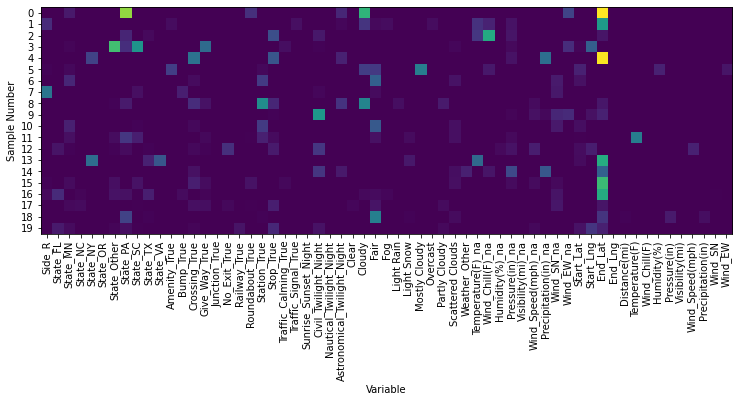

In [52]:
masks = feature_and_res['res_explain']
x_names = feature_and_res['x_names']
feature_importances = feature_and_res['feature_importances']
utils.plot_explain(masks[20:40],x_names)

In [7]:
masks.shape

(56907, 61)

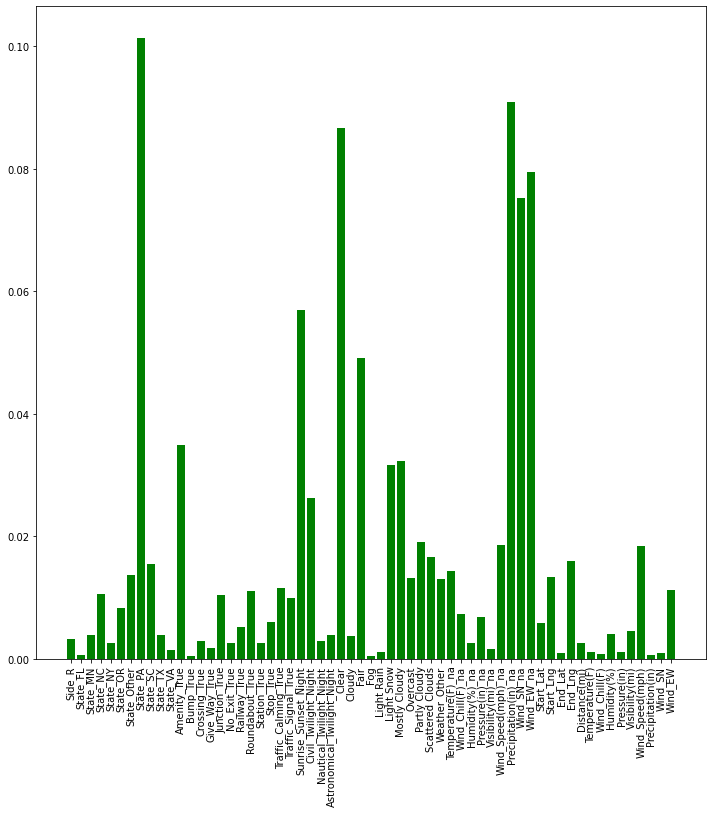

In [8]:
utils.plot_feature_importances(feature_importances,x_names)

In [44]:
with open('info-test/metrics.p','rb') as f:
    metrics = pickle.load(f)
print(metrics)

{'mcc': 0.09919160294486512, 'f1': 0.7790327553235775, 'confusion_m': array([[   63,   426,     7,    25],
       [ 1810, 41219,  4265,  3366],
       [   70,  1986,   753,   293],
       [   60,  1703,   531,   330]]), 'acc': 0.7444602597220026}


In [22]:
model.dls.valid

In [24]:
model.dls.valid.to('cuda')

In [46]:
import pandas as pd
pd.read_csv('info-test/train_history.csv')

,epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0,1.279747,1.342632,0.099192,01:36
